### RNNLM 구현

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### RNNLM의 학습 코드

In [2]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 400.43
| 에폭 2 | 퍼플렉서티 268.62
| 에폭 3 | 퍼플렉서티 227.16
| 에폭 4 | 퍼플렉서티 216.30
| 에폭 5 | 퍼플렉서티 204.89
| 에폭 6 | 퍼플렉서티 203.26
| 에폭 7 | 퍼플렉서티 198.98
| 에폭 8 | 퍼플렉서티 196.24
| 에폭 9 | 퍼플렉서티 190.82
| 에폭 10 | 퍼플렉서티 192.82
| 에폭 11 | 퍼플렉서티 189.31
| 에폭 12 | 퍼플렉서티 192.21
| 에폭 13 | 퍼플렉서티 189.44
| 에폭 14 | 퍼플렉서티 189.00
| 에폭 15 | 퍼플렉서티 189.07
| 에폭 16 | 퍼플렉서티 186.52
| 에폭 17 | 퍼플렉서티 183.75
| 에폭 18 | 퍼플렉서티 180.86
| 에폭 19 | 퍼플렉서티 182.53
| 에폭 20 | 퍼플렉서티 184.16
| 에폭 21 | 퍼플렉서티 181.29
| 에폭 22 | 퍼플렉서티 175.87
| 에폭 23 | 퍼플렉서티 175.61
| 에폭 24 | 퍼플렉서티 178.09
| 에폭 25 | 퍼플렉서티 174.29
| 에폭 26 | 퍼플렉서티 171.25
| 에폭 27 | 퍼플렉서티 167.95
| 에폭 28 | 퍼플렉서티 166.09
| 에폭 29 | 퍼플렉서티 164.58
| 에폭 30 | 퍼플렉서티 157.28
| 에폭 31 | 퍼플렉서티 159.93
| 에폭 32 | 퍼플렉서티 155.24
| 에폭 33 | 퍼플렉서티 154.46
| 에폭 34 | 퍼플렉서티 149.44
| 에폭 35 | 퍼플렉서티 147.51
| 에폭 36 | 퍼플렉서티 142.03
| 에폭 37 | 퍼플렉서티 134.21
| 에폭 38 | 퍼플렉서티 132.83
| 에폭 39 | 퍼플렉서티 129.20
| 에폭 40 | 퍼플렉서티 123.33
| 에폭 41 | 퍼플렉서티 124.40
| 에폭 42 | 퍼플렉서티 117.22
| 에폭 43 | 퍼플렉서티 112

<Figure size 640x480 with 1 Axes>

### RNNLM의 Trainer 클래스

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.43
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 353.89
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 246.48
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 218.22
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.62
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 207.68
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.99
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.11
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.48
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.98
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.26
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.71
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.02
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.80
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.45
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.70
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.81
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 185.07
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 181.48
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 181.29
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 178.46
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 177.

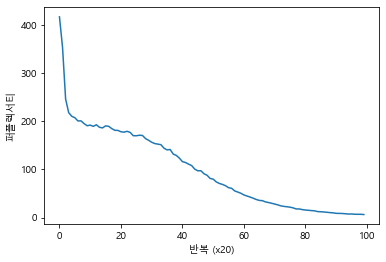

In [3]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()


In [1]:
import numpy as np

xs = np.arange(24).reshape(2,3,4)
# x  = xs[:, 0, :]
# print(x)

[[ 0  1  2  3]
 [12 13 14 15]]


In [4]:
import numpy as np

xs = np.arange(18).reshape(2,3,3)
print(xs)
rx  = xs.reshape(2*3,-1)
print(rx)

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]]
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
